[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Shipway_and_Hill_2012/fig_1.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Shipway_and_Hill_2012/fig_1.ipynb)

#### based on Fig. 1 from Shipway & Hill 2012 (Q. J. Royal Meteo. Soc. 138)  "_Diagnosis of systematic differences between multiple parametrizations of warm rain microphysics using a kinematic framework_"   
https://doi.org/10.1002/qj.1913

Including BREAKUP process to demonstrate physical changes to cloud.

**WARNING: TODO #819 - particles are not advected by the flow yet (only sedimentation causes displacement)**
**NOTE: constant momentum profile rather than constant velocity profile is used herein**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet --use-deprecated=legacy-resolver install \
            PySDM-examples \
            notebook==`python -c "import notebook; print(notebook.__version__)"` \
            tornado==`python -c "import tornado; print(tornado.version)"`
    !ldconfig

In [3]:
from PySDM_examples.Shipway_and_Hill_2012 import Settings, Simulation, plot
from PySDM.physics import si

## WITHOUT BREAKUP

In [4]:
# WITHOUT BREAKUP
n_sd_per_gridbox = 256
dt = 20*si.s
dz = 100*si.m

output = {}
rho_times_w = 3*si.m/si.s
precip = True
breakup = False
key = f"rhow={rho_times_w}_p={precip}"
output[key] = Simulation(Settings(n_sd_per_gridbox=n_sd_per_gridbox, 
    rho_times_w_1=rho_times_w, dt=dt, dz=dz, precip=precip, breakup=breakup)).run().products

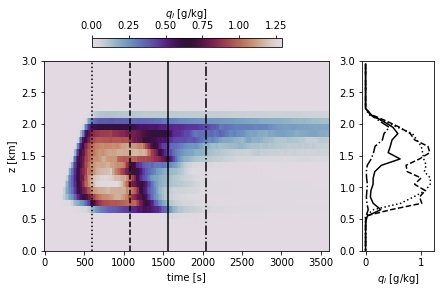

HTML(value="<a href='./ql_rhow=3_p=True.pdf' target='_blank'>./ql_rhow=3_p=True.pdf</a><br>")

In [5]:
line={10: ':', 18: '--', 26: '-', 34: '-.'}
plot(var='ql', qlabel='$q_l$ [g/kg]', fname=f'ql_rhow={int(rho_times_w)}_p={precip}.pdf', 
    output=output[f'rhow={int(rho_times_w)}.0_p={precip}'],vmin=0.0,vmax=1.0,line=line)

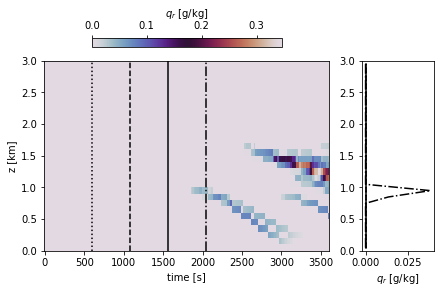

HTML(value="<a href='./qr_rhow=3_p=True.pdf' target='_blank'>./qr_rhow=3_p=True.pdf</a><br>")

In [6]:
line={10: ':', 18: '--', 26: '-', 34: '-.'}
plot(var='qr', qlabel='$q_r$ [g/kg]', fname=f'qr_rhow={int(rho_times_w)}_p={precip}.pdf', 
    output=output[f'rhow={int(rho_times_w)}.0_p={precip}'],vmin=0.0,vmax=1.0,line=line)

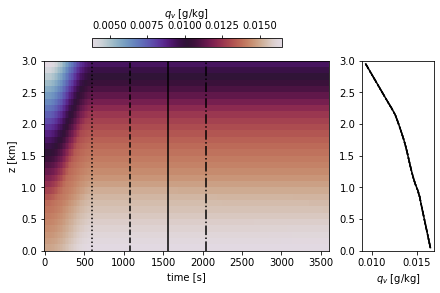

HTML(value="<a href='./qv_rhow=3_p=True.pdf' target='_blank'>./qv_rhow=3_p=True.pdf</a><br>")

In [7]:
line={10: ':', 18: '--', 26: '-', 34: '-.'}
plot(var='qv', qlabel='$q_v$ [g/kg]', fname=f'qv_rhow={int(rho_times_w)}_p={precip}.pdf', 
    output=output[f'rhow={int(rho_times_w)}.0_p={precip}'],vmin=0.0,vmax=20.0,line=line)

## WITH BREAKUP

In [9]:
# WITH BREAKUP
n_sd_per_gridbox = 256
dt = 20*si.s
dz = 100*si.m

output2 = {}
rho_times_w = 3*si.m/si.s
precip = True
breakup = True
key = f"rhow={rho_times_w}_p={precip}"
output2[key] = Simulation(Settings(n_sd_per_gridbox=n_sd_per_gridbox, rho_times_w_1=rho_times_w, 
    dt=dt, dz=dz, precip=precip, breakup=breakup)).run().products


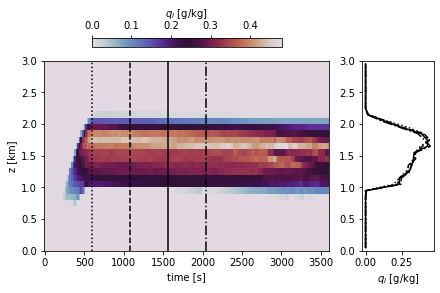

HTML(value="<a href='./ql_rhow=3_p=True_breakup.pdf' target='_blank'>./ql_rhow=3_p=True_breakup.pdf</a><br>")

In [10]:
line={10: ':', 18: '--', 26: '-', 34: '-.'}
plot(var='ql', qlabel='$q_l$ [g/kg]', fname=f'ql_rhow={int(rho_times_w)}_p={precip}_breakup.pdf', 
    output=output2[f'rhow={int(rho_times_w)}.0_p={precip}'],vmin=0.0,vmax=1.0,line=line)

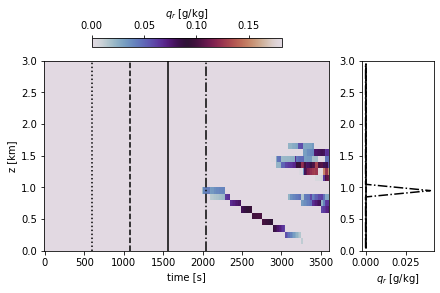

HTML(value="<a href='./qr_rhow=3_p=True_breakup.pdf' target='_blank'>./qr_rhow=3_p=True_breakup.pdf</a><br>")

In [11]:
line={10: ':', 18: '--', 26: '-', 34: '-.'}
plot(var='qr', qlabel='$q_r$ [g/kg]', fname=f'qr_rhow={int(rho_times_w)}_p={precip}_breakup.pdf', 
    output=output2[f'rhow={int(rho_times_w)}.0_p={precip}'],vmin=0.0,vmax=1.0,line=line)

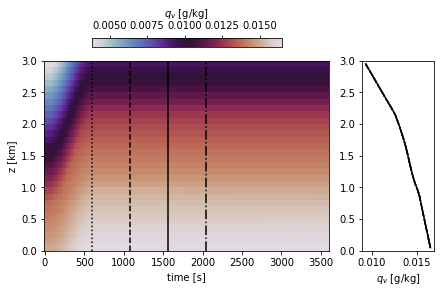

HTML(value="<a href='./qv_rhow=3_p=True_breakup.pdf' target='_blank'>./qv_rhow=3_p=True_breakup.pdf</a><br>")

In [12]:
line={10: ':', 18: '--', 26: '-', 34: '-.'}
plot(var='qv', qlabel='$q_v$ [g/kg]', fname=f'qv_rhow={int(rho_times_w)}_p={precip}_breakup.pdf', 
    output=output2[f'rhow={int(rho_times_w)}.0_p={precip}'],vmin=0.0,vmax=20.0,line=line)